Source: https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274/code 


**Reading data**

In [128]:
import os
#import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte
from skimage.transform import resize
#import skimage
#import glob
import random
#from random import randint, shuffle

from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy

model_checkpoint_file='bw_model_v3.h5'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
image_size = (128,128)

img_height
img_width =

In [129]:
## Import Training Data Images 
train_dirs = os.listdir(train_root)
train_filenames=[os.path.join(train_root,file_id) + "/images/"+file_id+".png" for file_id in train_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
train_images=[img_as_ubyte(imread(imagefile,as_grey=True)) for imagefile in train_filenames]

# Use this instead if you want color images
#train_images=[imread(imagefile) for imagefile in train_filenames]


C:\Users\jesse\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [36]:
## Import Training Masks

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, img_as_bool(imread(os.path.join(train_root,mask_file))))
        else:
            # read first mask in
            mask = img_as_bool(imread(os.path.join(train_root,mask_file)))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]

#def collapse_masks(mask_list):
#    for i, mask_file in enumerate(mask_list):
#        print(i)
#        print(mask_file)
        
#testing = [collapse_masks(mask_files) for mask_files in train_mask_files]

# Divide output of each mask by 255 to make a 1/0 binary mask
train_mask_images = [ collapse_masks(mask_files) for mask_files in train_mask_files ]


C:\Users\jesse\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


In [121]:
train_mask_images[0].min()

False

Image #: 275. Image Sizes: (256, 256) (256, 256)


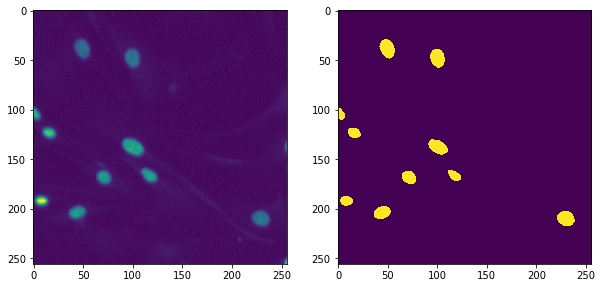

Image #: 308. Image Sizes: (256, 320) (256, 320)


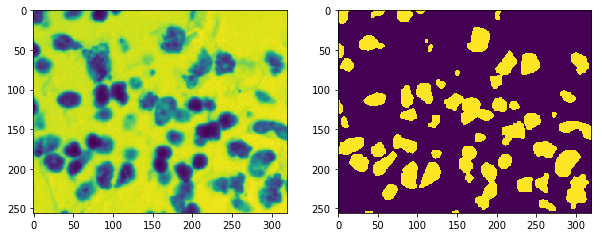

Image #: 360. Image Sizes: (256, 256) (256, 256)


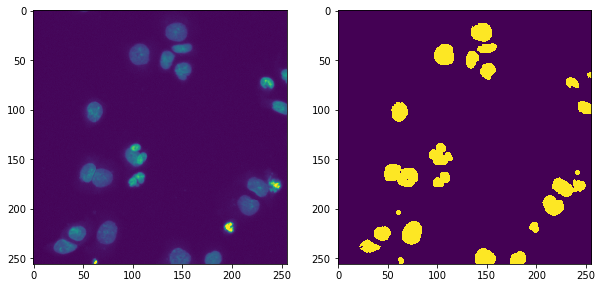

Image #: 24. Image Sizes: (256, 256) (256, 256)


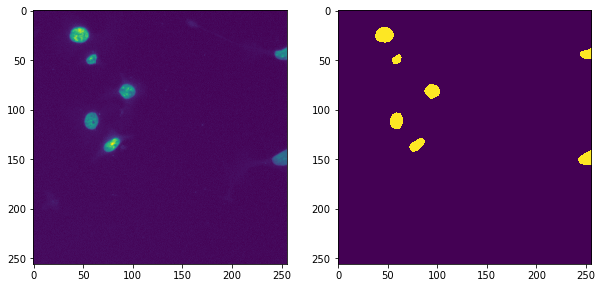

Image #: 135. Image Sizes: (256, 256) (256, 256)


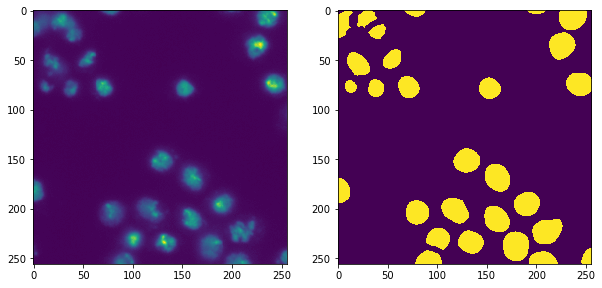

In [130]:
# Plot a training test and mask image side by side
def plot_side_by_side(image_ds,mask_ds,image_num):
    print('Image #: ' + str(image_num) + '. Image Sizes: ' + str(image_ds[image_num].shape) + ' ' + str(mask_ds[image_num].shape))
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_ds[image_num])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask_ds[image_num])
    plt.show()
    
# Plots random corresponding images and masks
def plot_check(images,masks,display_num):
    for i in range(display_num):
        plot_side_by_side(images,masks,randint(0,len(images)))
    
#plot_side_by_side(train_images,train_mask_images,38)
# Plot a few random images 
plot_check(train_images,train_mask_images,5)



In [142]:
# Resize everything
resized_train_images = [ img_as_ubyte(resize(image,image_size,mode='constant')) for image in train_images] 
resized_train_mask_images = [ img_as_bool(resize(image,image_size,mode='constant')) for image in train_mask_images] 



C:\Users\jesse\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jesse\Anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jesse\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


Image #: 2. Image Sizes: (128, 128) (128, 128)


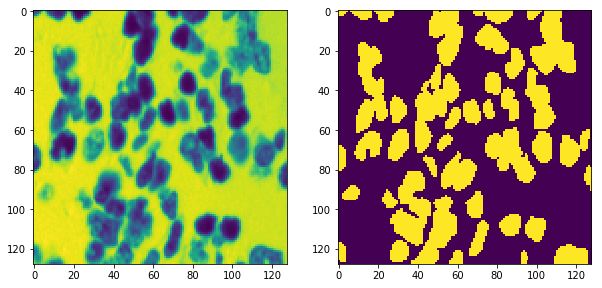

Image #: 640. Image Sizes: (128, 128) (128, 128)


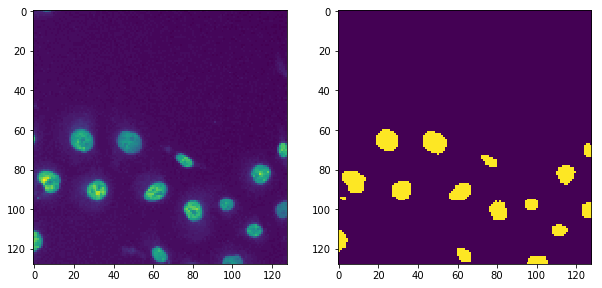

Image #: 151. Image Sizes: (128, 128) (128, 128)


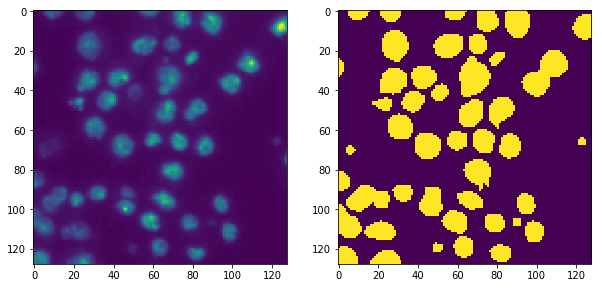

Image #: 213. Image Sizes: (128, 128) (128, 128)


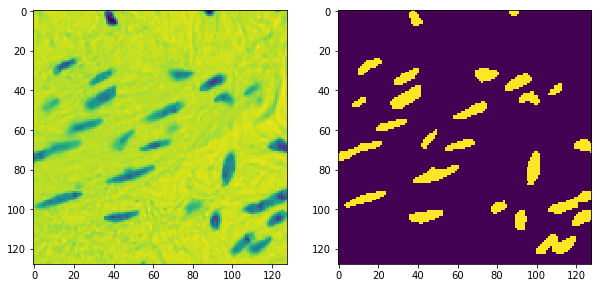

Image #: 72. Image Sizes: (128, 128) (128, 128)


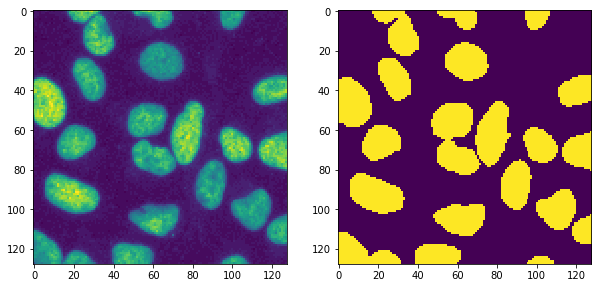

In [145]:
# Plot some resized images
plot_check(resized_train_images,resized_train_mask_images,5)

In [99]:
# Shuffle images and masks in same way (so that they still correspond)
# This might be redundant since you can do in the model fit stage

#all_train = list(zip(resized_train_images,resized_train_mask_images))
#random.shuffle(all_train)
#shuffled_train_images, shuffled_train_mask_images = zip(*all_train)



In [146]:
# Reshape model inputs
train_X = np.reshape(np.array(resized_train_images),(670,128,128,1))
train_Y = (np.reshape(np.array(resized_train_mask_images),(670,128,128,1)))

# Check size of arrays we are inputting to model
print(train_X.shape)
print(train_Y.shape)
print(train_X.nbytes)
print(train_Y.nbytes)

(670, 128, 128, 1)
(670, 128, 128, 1)
10977280
10977280


In [147]:
train_images[0].max()
#train_X[0]

108

Image #: 100. Image Sizes: (128, 128) (128, 128)


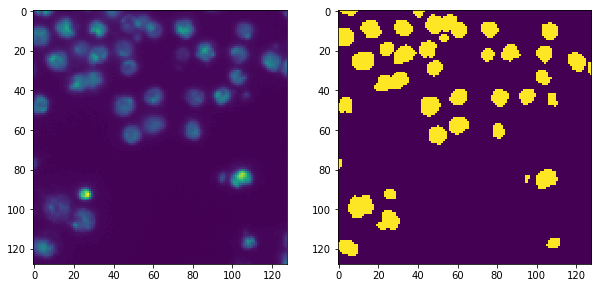

Image #: 100. Image Sizes: (256, 256) (256, 256)


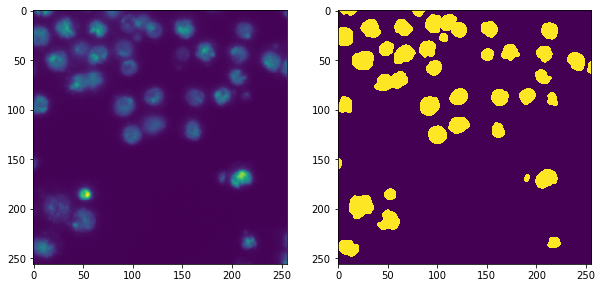

In [149]:
plot_side_by_side(np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3),100)
plot_side_by_side(train_images,train_mask_images,100)

# Now Let's Build a Neural Net

In [154]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=20, filter_size=(3, 3), activation='relu',dil_rate=(1,1),dropout_rate=0.2):
#    for i in range(n_block):
    x = Conv2D(filters, filter_size, padding='same', dilation_rate = dil_rate) (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(128, 128,1),
        num_filters=20,
        lr=0.01,
        loss=bce_dice_loss,
        n_class=1
):
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs)
    net_body = create_block(net_body)
    net_body = create_block(net_body)
    net_body = create_block(net_body,dil_rate=(2,2))
    net_body = create_block(net_body)
    net_body = create_block(net_body)
    # Sigmoid used since we are classifying pixels 1/0. Softmax used for multiclass
    classify = Conv2D(1,(1,1),activation='sigmoid')(net_body)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[dice_coef, binary_crossentropy])

    return model

In [155]:
my_model = get_net()

In [152]:
print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 20)      200       
_________________________________________________________________
activation_13 (Activation)   (None, 256, 256, 20)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256, 256, 20)      80        
_________________________________________________________________
dropout_13 (Dropout)         (None, 256, 256, 20)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 20)      3620      
_________________________________________________________________
activation_14 (Activation)   (None, 256, 256, 20)      0         
__________

In [156]:
# Fit model

# Implement learning rate decay https://keras.io/callbacks/#learningratescheduler 

earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5,
                           patience=3,
                           verbose=1,
                           mode='auto') 
# verbose=2 => one line per epoch, 1 = progress bar
results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=15, epochs=50, verbose=1 , shuffle=True,
                    callbacks=[earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/50
600/603 [============================>.] - ETA: 1s - loss: 0.9253 - dice_coef: 0.6190 - binary_crossentropy: 0.4110
Epoch 00001: val_loss improved from inf to 0.65384, saving model to bw_model_v3.h5
603/603 [==============================] - 237s 394ms/step - loss: 0.9276 - dice_coef: 0.6174 - binary_crossentropy: 0.4122 - val_loss: 0.6538 - val_dice_coef: 0.6976 - val_binary_crossentropy: 0.3192
Epoch 2/50
600/603 [============================>.] - ETA: 1s - loss: 0.6022 - dice_coef: 0.7007 - binary_crossentropy: 0.2511
Epoch 00002: val_loss improved from 0.65384 to 0.60951, saving model to bw_model_v3.h5
603/603 [==============================] - 233s 387ms/step - loss: 0.6049 - dice_coef: 0.6998 - binary_crossentropy: 0.2531 - val_loss: 0.6095 - val_dice_coef: 0.7359 - val_binary_crossentropy: 0.3323
Epoch 3/50
600/603 [============================>.] - ETA: 1s - loss: 0.4739 - dice_coef: 0.7612 - binary_crossentropy: 0.1878
Ep

Epoch 22/50
600/603 [============================>.] - ETA: 1s - loss: 0.2702 - dice_coef: 0.8653 - binary_crossentropy: 0.1087
Epoch 00022: val_loss improved from 0.27944 to 0.27374, saving model to bw_model_v3.h5
603/603 [==============================] - 212s 352ms/step - loss: 0.2704 - dice_coef: 0.8653 - binary_crossentropy: 0.1088 - val_loss: 0.2737 - val_dice_coef: 0.8548 - val_binary_crossentropy: 0.1088
Epoch 23/50
600/603 [============================>.] - ETA: 1s - loss: 0.2671 - dice_coef: 0.8665 - binary_crossentropy: 0.1084
Epoch 00023: val_loss improved from 0.27374 to 0.26380, saving model to bw_model_v3.h5
603/603 [==============================] - 212s 352ms/step - loss: 0.2669 - dice_coef: 0.8667 - binary_crossentropy: 0.1084 - val_loss: 0.2638 - val_dice_coef: 0.8650 - val_binary_crossentropy: 0.1058
Epoch 24/50
600/603 [============================>.] - ETA: 1s - loss: 0.2686 - dice_coef: 0.8660 - binary_crossentropy: 0.1093
Epoch 00024: val_loss did not improve
60

In [ ]:
Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Crop images to train networks faster for testing ??
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data